# MULTIHEAD ATTENTION

In [1]:
import numpy as np
import polars as pl
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

import re
from typing import List, Dict, Any, Tuple, Optional, Mapping, Set, Self, NamedTuple, TypedDict

In [2]:
def fix_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# BUILD TRANSFORMER

In [3]:
class RMSNorm(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        eps: float = 1e-6,
        bias: bool = False,
    ) -> None:
        super().__init__()
        self._eps = eps
        self._scale = nn.Parameter(torch.ones(embedding_size))
        self._shift = nn.Parameter(torch.zeros(embedding_size)) if bias else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_dtype = x.dtype

        variance = x.pow(2).mean(dim=-1, keepdim=True)
        norm_x = x * torch.rsqrt(variance + self._eps)
        norm_x = norm_x * self._scale

        if self._shift is not None:
            norm_x = norm_x + self._shift

        return norm_x.to(input_dtype)

In [4]:
class MoENoisyTopKGateFeedForward(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        num_experts: int,
        num_experts_per_token: int,
        moe_hidden_size: int,
        noisy_gating: bool = True,
    ) -> None:
        super().__init__()

        self._num_experts_per_tok = num_experts_per_token
        self._num_experts = num_experts
        self._embedding_size = embedding_size
        self.noisy_gating = noisy_gating
        self._gate = nn.Linear(embedding_size, num_experts, bias=False)

        # extra projection for Noisy Top-k Gating
        if noisy_gating:
            self._noise_linear = nn.Linear(embedding_size, num_experts, bias=False)

        self._fc1 = nn.ModuleList([
            nn.Linear(embedding_size, moe_hidden_size, bias=False)
            for _ in range(num_experts)
        ])
        self._fc2 = nn.ModuleList([
            nn.Linear(embedding_size, moe_hidden_size, bias=False)
            for _ in range(num_experts)
        ])
        self._fc3 = nn.ModuleList([
            nn.Linear(moe_hidden_size, embedding_size, bias=False)
            for _ in range(num_experts)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        scores = self._gate(x)  # (b, seq_len, num_experts)

        # ---------- 2. Add noise for Noisy Top-k ----------
        if self.noisy_gating and self.training:
            raw_noise_std = self._noise_linear(x)              # (B, S, E)
            noise_std = F.softplus(raw_noise_std) + 1e-9       # H(x) = softplus(...)
            noise = torch.randn_like(scores) * noise_std       # N(0, softplus(...))
            scores = scores + noise                                 # noisy top-k

        # ---------- 3. Top-k selection ----------
        topk_scores, topk_indices = torch.topk(
            scores, self._num_experts_per_tok, dim=-1
        )
        topk_probs = torch.softmax(topk_scores, dim=-1)

        self.last_topk_indices = topk_indices.detach()

        batch, seq_len, _ = x.shape
        x_flat = x.reshape(batch * seq_len, -1)
        out_flat = torch.zeros(batch * seq_len, self._embedding_size,
                               device=x.device, dtype=x.dtype)

        topk_indices_flat = topk_indices.reshape(-1, self._num_experts_per_tok)
        topk_probs_flat   = topk_probs.reshape(-1, self._num_experts_per_tok)

        unique_experts = torch.unique(topk_indices_flat)

        for expert_id_tensor in unique_experts:
            expert_id = int(expert_id_tensor.item())
            mask = topk_indices_flat == expert_id
            if not mask.any():
                continue

            token_mask = mask.any(dim=-1)
            selected_idx = token_mask.nonzero(as_tuple=False).squeeze(-1)
            if selected_idx.numel() == 0:
                continue

            expert_input = x_flat.index_select(0, selected_idx)

            hidden = (
                torch.nn.functional.silu(self._fc1[expert_id](expert_input)) *
                self._fc2[expert_id](expert_input)
            )
            expert_out = self._fc3[expert_id](hidden)

            mask_selected = mask[selected_idx]
            slot_indices = mask_selected.int().argmax(dim=-1, keepdim=True)

            selected_probs = torch.gather(
                topk_probs_flat.index_select(0, selected_idx),
                dim=-1,
                index=slot_indices
            ).squeeze(-1)

            out_flat.index_add_(
                0,
                selected_idx,
                expert_out * selected_probs.unsqueeze(-1)
            )

        return out_flat.reshape(batch, seq_len, self._embedding_size)

In [5]:
class MultiHeadLatentAttention(nn.Module):
    def __init__(
        self,
        num_heads: int,
        embedding_size: int,
        head_embedding_size: int,
        dropout: float,
        qkv_bias: bool = False,
        latent_dim: Optional[int] = None,
    ):
        super().__init__()

        self.num_heads = num_heads
        self.head_dim = head_embedding_size
        self.embedding_size = embedding_size
        self.d_out = num_heads * head_embedding_size

        # Latent-space dimensionality
        self.latent_dim = latent_dim if latent_dim is not None else max(16, self.d_out // 8)

        # ---------------------------------------------------------
        # Unified naming with classical MHA:
        #   W_Q : Query projection
        #   W_C : Down-projection → latent "C"
        #   W_K : Up-projection latent → Keys
        #   W_V : Up-projection latent → Values
        #   W_O : Output projection
        # ---------------------------------------------------------

        self.W_Q = nn.Linear(embedding_size, self.d_out, bias=qkv_bias)
        self.W_C = nn.Linear(embedding_size, self.latent_dim, bias=qkv_bias)

        self.W_K = nn.Linear(self.latent_dim, self.d_out, bias=qkv_bias)
        self.W_V = nn.Linear(self.latent_dim, self.d_out, bias=qkv_bias)

        self.W_O = nn.Linear(self.d_out, embedding_size)
        self.dropout = nn.Dropout(dropout)

        # Latent KV-cache
        self.register_buffer("cache_c_kv", None, persistent=False)
        self.ptr = 0

    def reset_cache(self):
        self.cache_c_kv = None
        self.ptr = 0

    @staticmethod
    def reshape_heads(x, num_heads, head_dim):
        # (b, T, num_heads * head_dim) → (b, num_heads, T, head_dim)
        b, T, _ = x.shape
        return x.view(b, T, num_heads, head_dim).transpose(1, 2).contiguous()

    def forward(self, x, attention_mask=None, use_cache: bool = False):
        """
        x: (batch, T, embedding_size)
        """
        b, T, _ = x.shape
        h = self.num_heads
        d = self.head_dim

        Q_all = self.W_Q(x)
        C_new = self.W_C(x)

        if use_cache:
            if self.cache_c_kv is None:
                C_total = C_new
            else:
                C_total = torch.cat([self.cache_c_kv, C_new], dim=1)

            self.cache_c_kv = C_total
        else:
            C_total = C_new

        K_all = self.W_K(C_total)
        V_all = self.W_V(C_total)

        Q = self.reshape_heads(Q_all, h, d)
        K = self.reshape_heads(K_all, h, d)
        V = self.reshape_heads(V_all, h, d)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1))

        T_Q = Q.shape[-2]
        T_K = K.shape[-2]

        device = Q.device

        if use_cache:
            q_pos = torch.arange(self.ptr, self.ptr + T_Q, device=device, dtype=torch.long)
            self.ptr += T_Q
        else:
            q_pos = torch.arange(T_Q, device=device, dtype=torch.long)
            self.ptr = 0

        k_pos = torch.arange(T_K, device=device, dtype=torch.long)

        causal_mask = q_pos.unsqueeze(-1) < k_pos.unsqueeze(0)
        attn_scores.masked_fill_(causal_mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / (K.shape[-1]**0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = (attn_weights @ V)
        context = context.transpose(1, 2).contiguous()\
                           .view(b, T, self.d_out)

        out = self.W_O(context)

        return out

In [6]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        num_heads: int,
        num_experts: int,
        num_experts_per_token: int,
        head_embedding_size: int,
        fcnn_hidden_size: int,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()

        self._mla = MultiHeadLatentAttention(
            embedding_size=embedding_size,
            num_heads=num_heads,
            head_embedding_size=head_embedding_size,
            dropout=dropout
        )

        self._fcnn = MoENoisyTopKGateFeedForward(
            embedding_size=embedding_size,
            num_experts=num_experts,
            num_experts_per_token=num_experts_per_token,
            moe_hidden_size=fcnn_hidden_size,
            noisy_gating=True
        )

        self._rms_norm1 = RMSNorm(embedding_size)
        self._rms_norm2 = RMSNorm(embedding_size)
        self._dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, attention_mask=None, use_cache: bool = False):
        z = self._rms_norm1(x)
        z = self._mla(z, attention_mask=attention_mask, use_cache=use_cache)
        x = x + self._dropout(z)

        z = self._rms_norm2(x)
        z = self._fcnn(z)
        return x + self._dropout(z)

Реализуем класс **MTPTransformer**, предназначенный для обучения модели на задаче предсказания следующих трёх токенов последовательности. Алгоритм реализован на основе методологии MTP (Multi-Token Prediction), предложенной в архитектуре DeepSeek.

In [7]:
class MTPTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_layers: int,
        embedding_size: int,
        num_heads: int,
        num_experts: int,
        num_experts_per_token: int,
        head_embedding_size: int,
        fcnn_hidden_size: int,
        dropout: float = 0.1,
        mtp_k: int = 3,
        max_seq_len: int = 2048,
    ) -> None:
        super().__init__()

        self.vocab_size = vocab_size
        self.mtp_k = mtp_k
        self.n_layers = n_layers
        self.embedding_size = embedding_size
        self.max_seq_len = max_seq_len

        self._embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            padding_idx=0,
        )

        self.main_layers = nn.ModuleList([
            DecoderLayer(
                embedding_size=embedding_size,
                num_heads=num_heads,
                num_experts=num_experts,
                num_experts_per_token=num_experts_per_token,
                head_embedding_size=head_embedding_size,
                fcnn_hidden_size=fcnn_hidden_size,
                dropout=dropout
            )
            for _ in range(n_layers)
        ])

        self.mtp_layers = nn.ModuleList([
            nn.ModuleList([
                DecoderLayer(
                    embedding_size=embedding_size,
                    num_heads=num_heads,
                    num_experts=num_experts,
                    num_experts_per_token=num_experts_per_token,
                    head_embedding_size=head_embedding_size,
                    fcnn_hidden_size=fcnn_hidden_size,
                    dropout=dropout
                )
                for _ in range(n_layers)
            ])
            for _ in range(mtp_k - 1)
        ])

        self._rms_norm = RMSNorm(embedding_size)
        self.projections = nn.ModuleList([
            nn.Linear(2 * embedding_size, embedding_size)
            for _ in range(mtp_k - 1)
        ])

        self._logits = nn.Linear(embedding_size, vocab_size, bias=False)
        self._logits.weight = self._embeddings.weight

    def forward(self, x: torch.LongTensor, attention_mask=None, use_cache: bool = False):
        B, T = x.shape

        # Валидация входа
        if T < self.mtp_k:
            raise ValueError(f"Sequence length {T} must be >= mtp_k={self.mtp_k}")

        max_seq_len = T - self.mtp_k

        # Эмбеддинги
        z = self._embeddings(x)

        # Основной путь
        h_main = z[:, :max_seq_len, :]
        for layer in self.main_layers:
            h_main = layer(h_main, attention_mask=attention_mask, use_cache=use_cache)

        logits_main = self._logits(h_main)
        outputs = [logits_main]
        h_prev = h_main

        # MTP этапы
        for k in range(1, self.mtp_k):
            start_idx = k
            end_idx = max_seq_len + k

            # Корректная индексация для MTP токенов
            h_curr_emb = z[:, start_idx:end_idx, :]

            # Нормализация и проекция
            h_norm = self._rms_norm(h_prev)
            e_norm = self._rms_norm(h_curr_emb)
            merged = torch.cat([h_norm, e_norm], dim=-1)
            h_prime = self.projections[k-1](merged)

            # MTP слой
            for layer in self.mtp_layers[k-1]:
                h_prime = layer(h_prime, attention_mask=attention_mask, use_cache=use_cache)
            h_k = h_prime

            logits_k = self._logits(h_k)
            outputs.append(logits_k)
            h_prev = h_k

        # Стек logits: [B, seq_len, mtp_k, vocab_size]
        return torch.stack(outputs, dim=2)

In [8]:
x = torch.LongTensor(
    [
        [3, 1, 2, 0, 0],
        [4, 1, 2, 0, 0],
        [3, 1, 2, 0, 0],
        [2, 1, 2, 4, 6],
    ]
)

transformer_mtp = MTPTransformer(
    vocab_size=50,
    n_layers=3,
    embedding_size=64,
    num_heads=8,
    num_experts=16,
    num_experts_per_token=8,
    head_embedding_size=32,
    fcnn_hidden_size=128,
    dropout = 0.1,
    mtp_k = 2
)

attention_mask = (x != 0).float()

output = transformer_mtp(x, attention_mask=attention_mask)
print(output.shape)

torch.Size([4, 3, 2, 50])


# TRAIN MODEL

#### Символьная языковая модель (character-level LM), которая обучена на корпусе имён и фамилий.

**Вход**: начальный текст, например "Красотка" (может быть имя или часть фамилии).

**Задача**: продолжить текст, сгенерировать следующие символы фамилии или имени, пока не встретится символ конца </s> или не будет достигнута максимальная длина.

In [9]:
class CharTokenizer:
    def __init__(self):
        self._start_token = "<s>"
        self._end_token = "</s>"
        self._unknown_token = "<UNK>"
        self._padding_token = "<PAD>"
        self._cls_token = "<CLS>"
        self._sep_token = "<SEP>"
        self._padding_id = 0
        self._cls_id = 1
        self._sep_id = 2
        self._start_token_id = 3
        self._end_token_id = 4
        self._unknown_token_id = 5
        self._init_vocab()

    @property
    def vocab(self) -> Mapping[int, str]:
        return self._vocab

    @property
    def reverse_vocab(self) -> Mapping[int, str]:
        return {token: id for id, token in self._vocab.items()}

    @property
    def start_token_id(self) -> int:
        return self._start_token_id

    @property
    def end_token_id(self) -> int:
        return self._end_token_id

    def _init_vocab(self) -> None:
        self._vocab = {
            self._padding_id: self._padding_token,
            self._cls_id: self._cls_token,
            self._sep_id: self._sep_token,
            self._start_token_id: self._start_token,
            self._end_token_id: self._end_token,
            self._unknown_token_id: self._unknown_token,
        }

    def fit(self, corpus: List[str]) -> Self:
        self._init_vocab()
        flat_corpus = "\n".join(corpus)
        for char in set(flat_corpus):
            if char in self._vocab.values():
                continue
            self._vocab[len(self._vocab)] = char
        return self

    def tokenize_text(self, text: str | List[str]) -> List[str] | List[List[str]]:
        if isinstance(text, str):
            return self._tokenize_text(text)
        assert isinstance(text, list), "`text` should be str or List[str]"
        return [self._tokenize_text(chunk) for chunk in text]

    def tokenize_ids(self, text: str | List[str]) -> List[int] | List[List[int]]:
        if isinstance(text, str):
            return self._tokenize_ids(text)
        assert isinstance(text, list), "`text` should be str or List[str]"
        return [self._tokenize_ids(chunk) for chunk in text]

    def decode(self, tokens: List[int]) -> str:
        content = []
        for token in tokens:
            if token in [self._padding_id, self._cls_id, self._sep_id, self._start_token_id, self._end_token_id, self._unknown_token_id]:
                continue
            content.append(
                self._vocab.get(token, self._unknown_token)
            )
        return "".join(content)

    def _tokenize_text(self, text: str) -> List[str]:
        tokens = [self._start_token]
        reverse_vocab = self.reverse_vocab
        for char in list(text):
            if char in reverse_vocab:
               tokens.append(char)
            else:
                tokens.append(self._unknown_token)
        tokens.append(self._end_token)
        return tokens

    def _tokenize_ids(self, text: str) -> List[int]:
        tokens = self._tokenize_text(text)
        reversed_vocab = self.reverse_vocab
        tokens_ids = [reversed_vocab[token] for token in tokens]
        return tokens_ids

In [10]:
names = pl.read_parquet("names.parquet")
surnames = pl.read_parquet("surnames.parquet")

def get_persons(names: pl.DataFrame, surnames: pl.DataFrame, n: int = 100) -> List[str]:
    persons = []
    for _ in range(n):
        sex = np.random.choice(["m", "f"]).item()
        name = names.filter(pl.col("gender") == sex).sample(1).select("text").item()
        surname = surnames.filter(pl.col("gender") == sex).sample(1).select("text").item()
        persons.append(f"{name} {surname}")
    return persons

corpus = get_persons(names, surnames, 10_000)
corpus[:10]

['Виталий Станченков',
 'Анжела Комденкова',
 'Марат Крапин',
 'Виталий Порубов',
 'Пётр Хацигов',
 'Валериан Шульганов',
 'Роза Девичева',
 'Олег Бузеев',
 'Василий Топинский',
 'Рафаил Шабашов']

In [11]:
tokenizer = CharTokenizer().fit(corpus)

In [12]:
tokenizer.vocab

{0: '<PAD>',
 1: '<CLS>',
 2: '<SEP>',
 3: '<s>',
 4: '</s>',
 5: '<UNK>',
 6: 'б',
 7: 'Д',
 8: '\n',
 9: 'У',
 10: 'к',
 11: 'г',
 12: 'х',
 13: 'у',
 14: 'Ч',
 15: 'К',
 16: 'ц',
 17: 'В',
 18: 'о',
 19: 'П',
 20: 'Щ',
 21: 'л',
 22: 'ь',
 23: 'Н',
 24: 'Э',
 25: 'ш',
 26: 'Л',
 27: ' ',
 28: 'е',
 29: 'М',
 30: 'Ш',
 31: 'v',
 32: 'й',
 33: '-',
 34: 'з',
 35: 'Б',
 36: 'Е',
 37: 'щ',
 38: 'И',
 39: 'р',
 40: '0',
 41: 'э',
 42: 'ё',
 43: 'ъ',
 44: 'h',
 45: 'т',
 46: 'Т',
 47: 'м',
 48: 'З',
 49: 'Я',
 50: ',',
 51: 'Х',
 52: 'п',
 53: 'с',
 54: 'а',
 55: 'я',
 56: 'Р',
 57: 'ж',
 58: 'Ю',
 59: 'в',
 60: 'Г',
 61: 'C',
 62: 'и',
 63: 'Ф',
 64: 'О',
 65: 'ю',
 66: 'А',
 67: 'н',
 68: 'С',
 69: 'ы',
 70: 'ф',
 71: 'Ц',
 72: 'д',
 73: 'ч',
 74: 'Ж',
 75: 'p'}

In [13]:
class SimpleTextDataset(Dataset):
    def __init__(
        self,
        corpus: List[str],
        fitted_tokenizer: CharTokenizer,
        max_seq_length: int = 100,
    ):
        self._data: List[List[int]] = []

        for sentence in corpus:
            x = fitted_tokenizer.tokenize_ids(sentence[:max_seq_length - 2])
            self._data.append(x)

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> Tuple[List[int], List[int]]:
        return torch.LongTensor(self._data[idx])


In [14]:
def collate(data: List[torch.Tensor]):
    x = [torch.LongTensor(seq) for seq in data]
    return nn.utils.rnn.pad_sequence(x, batch_first=True)

In [15]:
VOCAB_SIZE = len(tokenizer.vocab)
BATCH_SIZE = 256
MAX_SEQ_LEN = 200
N_LAYERS = 6
EMBEDDING_SIZE = 64
NUM_HEADS = 8
NUM_KV_GROUPS = 2
NUM_EXPERTS = 16
NUM_EXPERTS_PER_TOKEN = 2
HEAD_EMBEDDING_SIZE = EMBEDDING_SIZE // NUM_HEADS
FCCN_HIDDEN_SIZE = EMBEDDING_SIZE * 4
MTP_K = 3
n_epoch = 20

In [16]:
dataset = SimpleTextDataset(
    corpus=corpus,
    fitted_tokenizer=tokenizer,
    max_seq_length=MAX_SEQ_LEN,
)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate
)

In [17]:
next(iter(dataloader)).shape

torch.Size([256, 25])

In [18]:
transformer_mtp = MTPTransformer(
    vocab_size=VOCAB_SIZE,
    n_layers=N_LAYERS,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_experts=NUM_EXPERTS,
    num_experts_per_token=NUM_EXPERTS_PER_TOKEN,
    head_embedding_size=HEAD_EMBEDDING_SIZE,
    fcnn_hidden_size=FCCN_HIDDEN_SIZE,
    dropout = 0.15,
    mtp_k = MTP_K
)

optimizer = Adam(transformer_mtp.parameters(), lr=4e-3)
loss_func = nn.CrossEntropyLoss(reduction='none')

In [19]:
import math
import torch
import torch.nn.functional as F

def compute_perplexity(model, dataloader, loss_func, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)  # [B, T]
            
            # Создаем attention mask
            attention_mask = (x != 0).float()  # [B, T]
            
            curr_x = x[:, :-1]        # [B, T-1] вход
            next_x = x[:, 1:]         # [B, T-1] цели
            
            # Передаем маску в модель
            logits = model(curr_x, attention_mask=attention_mask[:, :-1])  # [B, L, K, V]
            B, L, K, V = logits.shape

            # Только main head (k=0)
            logits_main = logits[:, :, 0, :]      # [B, L, V]
            targets = next_x[:, :L]               # [B, L]

            # Маска для валидных токенов (не PAD и не EOS)
            mask = (targets != 0) & (targets != 4)  # [B, L]

            if mask.any():
                logits_flat = logits_main[mask]     # [N, V]
                targets_flat = targets[mask]        # [N]

                ce = F.cross_entropy(
                    logits_flat,
                    targets_flat,
                    reduction='sum'
                )
                total_loss += ce.item()
                total_tokens += mask.sum().item()

    if total_tokens == 0:
        return float('inf')

    mean_nll = total_loss / total_tokens
    return math.exp(mean_nll)

In [26]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def train_and_collect(model, n_epoch, dataloader, loss_func, optimizer, num_experts, device, mtp_lambda=0.3):
    epoch_loss = []
    expert_usage_list = []
    ppl_list = []

    for epoch in range(n_epoch):
        model.train()
        losses = []
        print(f"Epoch {epoch+1}")

        all_layers_topk_indices = []

        for x in tqdm(dataloader):
            B, T = x.shape
            K = model.mtp_k
            V = model.vocab_size  # Размерность словаря (предположим, что ты знаешь V заранее)

            # === НОВОЕ: Создаем attention mask ===
            attention_mask = (x != 0).float().to(device)  # [B, T]

            # Вход для модели
            curr_x = x[:, :T-K].to(device)      # [B, T-K]
            full_next_x = x[:, 1:T].to(device)  # [B, T-1]
            
            # === ПЕРЕДАЕМ МАСКУ В МОДЕЛЬ ===
            logits = model(curr_x, attention_mask=attention_mask[:, :T-K], use_cache=False)
            B_out, L, K_out, V = logits.shape

            # ===== Main loss =====
            main_logits = logits[:, :, 0, :].reshape(-1, V)
            main_targets = full_next_x[:, :L].reshape(-1)

            main_mask = main_targets != 0
            main_loss_per_token = loss_func(main_logits, main_targets)
            main_loss_per_token = main_loss_per_token[main_mask]

            main_loss = (
                main_loss_per_token.mean()
                if main_loss_per_token.numel() > 0
                else torch.tensor(0.0, device=device)
            )

            # ===== MTP loss =====
            mtp_loss = 0.0

            for k in range(1, K_out):
                mtp_logits = logits[:, :, k, :].reshape(-1, V)
                mtp_targets = full_next_x[:, k:k+L].reshape(-1)

                mtp_mask = mtp_targets != 0
                if mtp_mask.sum() == 0:
                    continue

                loss_per_token = loss_func(mtp_logits, mtp_targets)
                mtp_loss += loss_per_token[mtp_mask].mean()

            # Скалируем MTP loss по количеству слоев
            mtp_loss = (mtp_loss / max(1, K_out - 1)) * mtp_lambda

            # Общая потеря
            total_loss = main_loss + mtp_loss
            losses.append(total_loss.item())

            # MoE usage (без изменений)
            batch_indices = []
            for layer in model.main_layers:
                if hasattr(layer._fcnn, 'last_topk_indices') and layer._fcnn.last_topk_indices is not None:
                    batch_indices.append(layer._fcnn.last_topk_indices.detach())
            for block in model.mtp_layers:  # mtp_block - это MTPBlock
                for layer in block:  # layer - это DecoderLayer
                    if hasattr(layer._fcnn, 'last_topk_indices') and layer._fcnn.last_topk_indices is not None:
                        batch_indices.append(layer._fcnn.last_topk_indices.detach())

            if batch_indices:
                combined_batch = torch.cat(batch_indices, dim=0)
                all_layers_topk_indices.append(combined_batch)

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Подсчет потерь по эпохам
        epoch_loss.append(np.mean(losses))

        # Подсчет использования экспертов
        if all_layers_topk_indices:
            all_topk_flat = torch.cat([t.reshape(-1) for t in all_layers_topk_indices])
            usage = np.array([(all_topk_flat.cpu().numpy() == i).sum() for i in range(num_experts)])
        else:
            usage = np.zeros(num_experts, dtype=int)

        expert_usage_list.append(usage)

        # Подсчет PPL (перплексии)
        ppl = compute_perplexity(model, dataloader, loss_func, device)
        ppl_list.append(ppl)

        # Печать результата по эпохам
        print(f"Loss: {epoch_loss[-1]:.4f} | PPL: {ppl:.4f}")

    return epoch_loss, expert_usage_list, ppl_list

In [27]:
device = "cuda"
transformer_mtp.to(device)

loss_mha, usage_mha, ppl_mha = train_and_collect(
  transformer_mtp, 100, dataloader, loss_func, optimizer, NUM_EXPERTS, device
)


Epoch 1


100%|██████████| 40/40 [00:18<00:00,  2.21it/s]


Loss: 7.2362 | PPL: 9.7483
Epoch 2


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 2.5217 | PPL: 5.7023
Epoch 3


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 2.0849 | PPL: 4.8193
Epoch 4


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.9405 | PPL: 4.4533
Epoch 5


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.8768 | PPL: 4.4442
Epoch 6


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.8460 | PPL: 4.2595
Epoch 7


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.8064 | PPL: 4.2361
Epoch 8


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.7951 | PPL: 4.1650
Epoch 9


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.7757 | PPL: 4.1355
Epoch 10


100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Loss: 1.7583 | PPL: 4.0455
Epoch 11


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.7390 | PPL: 4.0460
Epoch 12


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.7311 | PPL: 3.9675
Epoch 13


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.7292 | PPL: 3.9517
Epoch 14


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.7154 | PPL: 3.9531
Epoch 15


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.7071 | PPL: 3.9285
Epoch 16


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.6918 | PPL: 3.9190
Epoch 17


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.6798 | PPL: 3.8430
Epoch 18


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.6800 | PPL: 3.7917
Epoch 19


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.6664 | PPL: 3.7820
Epoch 20


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.6537 | PPL: 3.7503
Epoch 21


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.6429 | PPL: 3.7565
Epoch 22


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.6397 | PPL: 3.7176
Epoch 23


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.6338 | PPL: 3.6820
Epoch 24


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.6285 | PPL: 3.6589
Epoch 25


100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Loss: 1.6206 | PPL: 3.6403
Epoch 26


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.6139 | PPL: 3.6555
Epoch 27


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.6104 | PPL: 3.6186
Epoch 28


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.5942 | PPL: 3.5976
Epoch 29


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.5941 | PPL: 3.5534
Epoch 30


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.5869 | PPL: 3.5259
Epoch 31


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.5732 | PPL: 3.4779
Epoch 32


100%|██████████| 40/40 [00:17<00:00,  2.31it/s]


Loss: 1.5673 | PPL: 3.5180
Epoch 33


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.5626 | PPL: 3.4802
Epoch 34


100%|██████████| 40/40 [00:17<00:00,  2.30it/s]


Loss: 1.5492 | PPL: 3.4455
Epoch 35


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.5446 | PPL: 3.4217
Epoch 36


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.5396 | PPL: 3.3638
Epoch 37


100%|██████████| 40/40 [00:17<00:00,  2.30it/s]


Loss: 1.5346 | PPL: 3.3542
Epoch 38


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.5220 | PPL: 3.3609
Epoch 39


100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


Loss: 1.5198 | PPL: 3.2961
Epoch 40


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.5090 | PPL: 3.3095
Epoch 41


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.5079 | PPL: 3.2905
Epoch 42


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.4955 | PPL: 3.2149
Epoch 43


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.4900 | PPL: 3.2118
Epoch 44


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.4766 | PPL: 3.1630
Epoch 45


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.4772 | PPL: 3.1529
Epoch 46


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.4657 | PPL: 3.1339
Epoch 47


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.4590 | PPL: 3.1339
Epoch 48


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.4571 | PPL: 3.0885
Epoch 49


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.4420 | PPL: 3.0703
Epoch 50


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.4397 | PPL: 3.0430
Epoch 51


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.4329 | PPL: 3.0260
Epoch 52


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.4312 | PPL: 3.0294
Epoch 53


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.4137 | PPL: 2.9761
Epoch 54


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.4135 | PPL: 2.9491
Epoch 55


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.4051 | PPL: 2.9415
Epoch 56


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.3999 | PPL: 2.9091
Epoch 57


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.3949 | PPL: 2.9124
Epoch 58


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.3905 | PPL: 2.8887
Epoch 59


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.3820 | PPL: 2.8730
Epoch 60


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.3786 | PPL: 2.8386
Epoch 61


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.3697 | PPL: 2.8059
Epoch 62


100%|██████████| 40/40 [00:16<00:00,  2.35it/s]


Loss: 1.3638 | PPL: 2.7991
Epoch 63


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.3501 | PPL: 2.7873
Epoch 64


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.3455 | PPL: 2.7665
Epoch 65


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.3393 | PPL: 2.7329
Epoch 66


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.3426 | PPL: 2.7173
Epoch 67


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.3237 | PPL: 2.7098
Epoch 68


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.3249 | PPL: 2.6948
Epoch 69


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.3189 | PPL: 2.6715
Epoch 70


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.3113 | PPL: 2.6725
Epoch 71


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.3067 | PPL: 2.6311
Epoch 72


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.3025 | PPL: 2.6194
Epoch 73


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.2931 | PPL: 2.6088
Epoch 74


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.2914 | PPL: 2.5702
Epoch 75


100%|██████████| 40/40 [00:17<00:00,  2.31it/s]


Loss: 1.2777 | PPL: 2.5499
Epoch 76


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.2713 | PPL: 2.5567
Epoch 77


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.2690 | PPL: 2.5654
Epoch 78


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.2625 | PPL: 2.5184
Epoch 79


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.2643 | PPL: 2.5121
Epoch 80


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.2534 | PPL: 2.4801
Epoch 81


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.2480 | PPL: 2.4616
Epoch 82


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.2444 | PPL: 2.4534
Epoch 83


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.2381 | PPL: 2.4465
Epoch 84


100%|██████████| 40/40 [00:17<00:00,  2.30it/s]


Loss: 1.2331 | PPL: 2.4232
Epoch 85


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.2305 | PPL: 2.4414
Epoch 86


100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 1.2249 | PPL: 2.4130
Epoch 87


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.2179 | PPL: 2.4133
Epoch 88


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.2161 | PPL: 2.3838
Epoch 89


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.2102 | PPL: 2.3671
Epoch 90


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Loss: 1.2081 | PPL: 2.3842
Epoch 91


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.2022 | PPL: 2.3628
Epoch 92


100%|██████████| 40/40 [00:17<00:00,  2.31it/s]


Loss: 1.1983 | PPL: 2.3364
Epoch 93


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.1987 | PPL: 2.3513
Epoch 94


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.1923 | PPL: 2.3259
Epoch 95


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.1830 | PPL: 2.3073
Epoch 96


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.1771 | PPL: 2.3017
Epoch 97


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Loss: 1.1737 | PPL: 2.2888
Epoch 98


100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Loss: 1.1739 | PPL: 2.2802
Epoch 99


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 1.1725 | PPL: 2.2650
Epoch 100


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Loss: 1.1679 | PPL: 2.2659


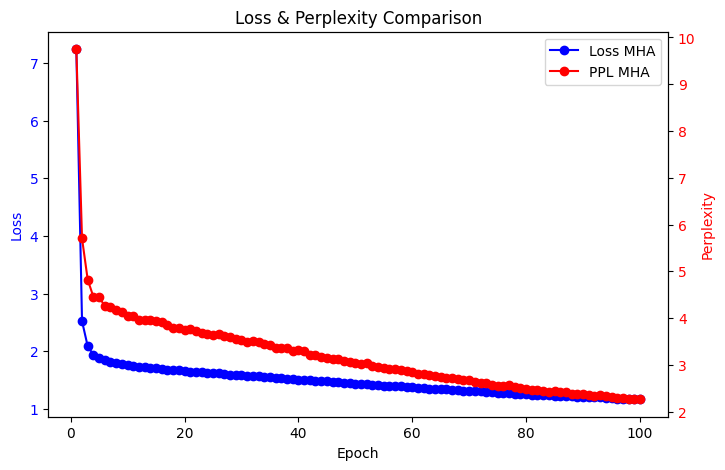

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_mha)+1)

fig, ax1 = plt.subplots(figsize=(8,5))

# ===== Loss =====
ax1.plot(epochs, loss_mha, 'b-o', label='Loss MHA')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# ===== PPL =====
ax2 = ax1.twinx()  # создаем вторую ось Y
ax2.plot(epochs, ppl_mha, 'r-o', label='PPL MHA')
ax2.set_ylabel('Perplexity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# ===== легенда =====
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Loss & Perplexity Comparison")
plt.show()

In [29]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to megabytes
    total_memory_mb = total_memory_bytes / (1024**2)

    return total_memory_mb

print(f"float32 (PyTorch default): {model_memory_size(transformer_mtp, input_dtype=torch.float32):.4f} MB")
print(f"bfloat16: {model_memory_size(transformer_mtp, input_dtype=torch.bfloat16):.4f} MB")

float32 (PyTorch default): 110.0181 MB
bfloat16: 55.0090 MB


# TEST MODEL

In [30]:
def generate(
    model: nn.Module,
    text_input: str,
    tokenizer: CharTokenizer,
    max_steps: int = 100,
    device: str = "cuda",
    temperature: float = 1.0,
    top_k: int = 50
) -> str:
    model.eval()
    model.to(device)

    # Токенизируем вход
    input_tokens = tokenizer.tokenize_ids(text_input)
    x = torch.tensor([input_tokens], dtype=torch.long, device=device)  # [1, T]

    generated_tokens = input_tokens.copy()

    for step in range(max_steps):
        with torch.no_grad():
            # **КЛЮЧЕВОЕ: используем ТОЛЬКО main prediction k=0**
            logits = model(x)  # [1, L, K, V]

            # Берем logits с последней позиции, main head (k=0)
            next_logits = logits[0, -1, 0] / temperature  # [V]

            # Top-K sampling
            if top_k > 0:
                v, _ = torch.topk(next_logits, min(top_k, next_logits.size(-1)))
                next_logits[torch.lt(next_logits, v[0])] = -float('Inf')

            probs = F.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        next_token_id = next_token.item()
        generated_tokens.append(next_token_id)

        # Останавливаемся на EOS
        if next_token_id == 4:  # <EOS>
            break

        # Добавляем токен к последовательности
        x = torch.cat([x, next_token.unsqueeze(0)], dim=1)

    return tokenizer.decode(generated_tokens)

In [31]:
transformer_mtp.eval()

MTPTransformer(
  (_embeddings): Embedding(76, 64, padding_idx=0)
  (main_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (_mla): MultiHeadLatentAttention(
        (W_Q): Linear(in_features=64, out_features=64, bias=False)
        (W_C): Linear(in_features=64, out_features=16, bias=False)
        (W_K): Linear(in_features=16, out_features=64, bias=False)
        (W_V): Linear(in_features=16, out_features=64, bias=False)
        (W_O): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
      )
      (_fcnn): MoENoisyTopKGateFeedForward(
        (_gate): Linear(in_features=64, out_features=16, bias=False)
        (_noise_linear): Linear(in_features=64, out_features=16, bias=False)
        (_fc1): ModuleList(
          (0-15): 16 x Linear(in_features=64, out_features=256, bias=False)
        )
        (_fc2): ModuleList(
          (0-15): 16 x Linear(in_features=64, out_features=256, bias=False)
        )
        (_fc3): ModuleList

In [36]:
generate(
    model=transformer_mtp,
    text_input="Красота",
    tokenizer=tokenizer,
    device=device,
)

'Красотаваниь тняСрукеисовноваава'